In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the pre-built convolutional neural network

- InceptionNet: https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3
- Original paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf
- Imagenet: http://www.image-net.org/

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top = False, weights = "imagenet")
base_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
len(base_model.layers)

311

In [ ]:
# Relu
# names = ["mixed3","mixed5","mixed8","mixed9"]
names = ["mixed3","mixed5"]

In [ ]:
base_model.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
layers = [base_model.get_layer(name).output for name in names]
layers

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

In [ ]:
deep_dream_model = tf.keras.models.Model(inputs = base_model.input, outputs = layers)
len(deep_dream_model.layers)

165

# Loading And Pre-Processing The Images

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/OpenCV/Images/StaryNight.jpg",
                                              target_size = (225,375))

type(image),image.size,len(image.mode)

(PIL.Image.Image, (375, 225), 3)

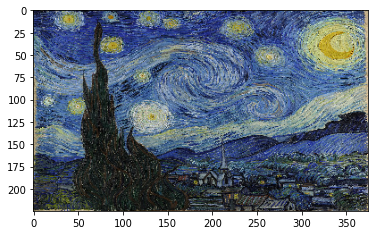

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
list(image.getdata())

In [ ]:
image = tf.keras.preprocessing.image.img_to_array(image)

type(image),image.shape

(numpy.ndarray, (225, 375, 3))

In [ ]:
image.max(),image.min()

(255.0, 0.0)

In [ ]:
image = tf.keras.applications.inception_v3.preprocess_input(image)

image.max(),image.min(),image.shape

(1.0, -1.0, (225, 375, 3))

# Getting The Activations

In [ ]:
image_batch = tf.expand_dims(image, axis = 0)
image_batch.shape

TensorShape([1, 225, 375, 3])

In [ ]:
# Brief

image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/OpenCV/Images/StaryNight.jpg",target_size = (225,375))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.inception_v3.preprocess_input(image)
image_batch = tf.expand_dims(image, axis = 0)
image.shape, image_batch.shape

((225, 375, 3), TensorShape([1, 225, 375, 3]))

In [ ]:
activations = deep_dream_model.predict(image_batch)
len(activations)

2

In [ ]:
deep_dream_model.outputs

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

In [ ]:
activations[0].shape,activations[1].shape

((1, 12, 21, 768), (1, 12, 21, 768))

# Calculating The Loss

In [ ]:
def calculate_loss(image, network):

    image_batch = tf.expand_dims(image, axis = 0)
    activations = network(image_batch)

    losses = []
    for act in activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)

In [ ]:
activations[0].mean() + activations[1].mean()

0.6168045

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


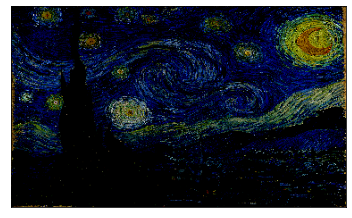

In [ ]:
plt.imshow(image)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
# Kendi elimizdede yaptık !!!

loss = calculate_loss(image, deep_dream_model)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.6168045>

# Gradient Ascent

In [ ]:
# Compare the activations with the pixels
# Emphasize parts of the image
# Change the pixels of the input image

@tf.function
def deep_dream(network, image, learning_rate):

    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = calculate_loss(image, network)

    gradients = tape.gradient(loss, image)
    gradients /=tf.math.reduce_std(gradients)
    image = image + gradients * learning_rate
    image = tf.clip_by_value(image, -1, 1)
    
    return loss, image

In [ ]:
#test_loss, test_image = deep_dream(deep_dream_model, image, 0.01)

In [ ]:
def inverse_transform(image):

    # Çünkü min değer -1 olduğu için artı 1 ve  max değer ise 1 ve +1 ile 2 olduğu için 2 bölüyoruz..
    
    image = 255*(image + 1 ) / 2.0
    return tf.cast(image, tf.uint8)

In [ ]:
def run_deep_dream(network, image, epochs , learning_rate):

    for epoch in range(epochs):
        loss, image = deep_dream(network, image, learning_rate)

        if epoch % 200 == 0:
            
            plt.figure(figsize = (12,12))
            plt.imshow(inverse_transform(image))
            plt.title("Epoch : {}, Loss : {}".format(epoch, loss),fontsize = 15)
            plt.show()
            

# Generating Images

In [ ]:
image.max(),image.min(),image.shape,type(image)

(1.0, -1.0, (225, 375, 3), numpy.ndarray)

In [ ]:
image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/OpenCV/Images/StaryNight.jpg",target_size = (225,375))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.inception_v3.preprocess_input(image)
image.max(),image.min(),image.shape,type(image)

(1.0, -1.0, (225, 375, 3), numpy.ndarray)

In [ ]:
run_deep_dream(network = deep_dream_model, image = image, epochs = 8000, learning_rate = 0.0001)

# HomeWork And Summary

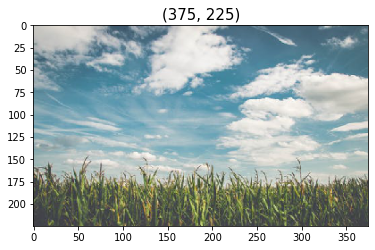

In [ ]:
image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/OpenCV/Images/sky.jpeg",target_size = (225,375))
plt.imshow(image)
plt.title(image.size, fontsize = 15)
plt.show()

image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.inception_v3.preprocess_input(image)

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top = False, weights = "imagenet")
names = ["mixed3","mixed5"]
layers = [base_model.get_layer(name).output for name in names]
deep_dream_model = tf.keras.models.Model(inputs = base_model.input , outputs = layers)

def calculate_loss(image, network):

    image_batch = tf.expand_dims(image,axis = 0)
    activations = network(image_batch)

    losses = []
    for act in activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)

@tf.function
def deep_dream(network, image, learning_rate):

    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = calculate_loss(image, network)


    gradients = tape.gradient(loss, image) # Derivate
    gradients /= tf.math.reduce_std(gradients)
    image = image + gradients * learning_rate
    image = tf.clip_by_value(image, -1 , 1)

    return loss, image

def inverse_image(image):
    image = 255 * (image + 1.0) / 2.0
    return tf.cast(image,tf.uint8)

def run_deep_dream(network, image, epochs , learning_rate):

    for epoch in range(epochs):

        loss, image = deep_dream(network,image,learning_rate)

        if epoch % 200 == 0:

            plt.figure(figsize = (12,12))
            plt.imshow(inverse_transform(image))
            plt.title(f"Epoch : {epoch}, Loss : {loss}",fontsize = 15)
            plt.show()

run_deep_dream(deep_dream_model, image, 1000, 0.01)